# Style Transfer CycleGAN

---
Author: Alex Navarro

Base: SIMPLE GAN colab 
Author: Albert Pumarola

DataSet Loader and Optimization step loop: Cycle GAN Horse2Zebra 
Author: Ramon Planas

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [3]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/

for details.

--2020-03-15 16:56:22--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  96.8MB/s    in 1.2s    

2020-03-15 16:56:23 (96.8 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

**Generate Dataset class**

In [0]:
class Horse2ZebraDataset(Dataset):
  """
  Dataset class to load images
  """
  def __init__(self, root_dir, transform=None):
    """
    Args:
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    self.root_dir = root_dir
    self.transform = transform
    self.list_images = os.listdir(self.root_dir)

  def __len__(self):
    return len(self.list_images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.list_images[idx])
    image = Image.open(img_name)

    if self.transform:
      image = self.transform(image)

    return image

class TwoDatasets(Dataset):
  """
  Dataset class to get samples from two different image collections
  """
  def __init__(self, root_dirA, root_dirB, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform=transform

  def __len__(self):
    return min(len(self.filelistA),len(self.filelistB))

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


In [0]:
image_size = 128
tf = transforms.Compose(
    [transforms.Resize(image_size, interpolation=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

#horse2zebra_trainA = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/trainA', transform=tf)
#horse2zebra_testA  = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/testA', transform=tf)

#horse2zebra_trainB = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/trainB', transform=tf)
#horse2zebra_testB  = Horse2ZebraDataset(root_dir='./datasets/horse2zebra/testB', transform=tf)

horse2zebra_train = TwoDatasets(root_dirA='./datasets/horse2zebra/trainA',root_dirB='./datasets/horse2zebra/trainB', transform=tf)
horse2zebra_test  = TwoDatasets(root_dirA='./datasets/horse2zebra/testA', root_dirB='./datasets/horse2zebra/testB',  transform=tf)

## Data Loader
Create data loaders for the horse2zebra dataset

In [0]:
batch_size = 1
#data_loader_trainA = torch.utils.data.DataLoader(horse2zebra_trainA, batch_size=batch_size, shuffle=True)
#data_loader_testA  = torch.utils.data.DataLoader(horse2zebra_testA,  batch_size=batch_size, shuffle=True)
#data_loader_trainB = torch.utils.data.DataLoader(horse2zebra_trainB, batch_size=batch_size, shuffle=True)
#data_loader_testB  = torch.utils.data.DataLoader(horse2zebra_testB,  batch_size=batch_size, shuffle=True)

data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size=batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size=batch_size, shuffle=True)


Show some examples

1067
120


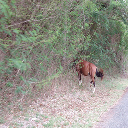

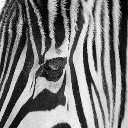

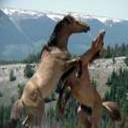

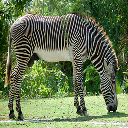

In [7]:
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])

## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder
        self._encoder1 = self.encoder(3, 64, 4)
        self._encoder2 = self.encoder(64, 128, 4)
        self._encoder3 = self.encoder(128, 256, 4)

        # Residual net
        self._res1 = self.residual(256, 256, 3)
        self._res2 = self.residual(256, 256, 3)
        self._res3 = self.residual(256, 256, 3)
        
        # Decoder
        self._decoder1 = self.decoder(256, 128, 4)
        self._decoder2 = self.decoder(128, 64, 4)
        self._decoder3 = self.decoder2(64, 3, 4)

    def encoder(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), #Dropout in every layer
            nn.LeakyReLU(0.2)
        )
        return x

    def residual(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), #Dropout in every layer
            nn.LeakyReLU(0.2),
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), #Dropout in every layer
            nn.LeakyReLU(0.2)
        )
        return x

    def decoder(self, i, o, dim):
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            #nn.Dropout2d(), #Dropout in every layer
            nn.ReLU() #nn.LeakyReLU(0.2)
        )
        return x

    def decoder2(self, i, o, dim): #Same as previous without normalization and changing Relu by Tanh
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            #nn.Dropout2d(), #Dropout in every layer
            nn.Tanh()
        )
        return x   

    def forward(self, x):
        # Encode
        #m0 = x
        x = self._encoder1(x)
        #m1 = x
        x = self._encoder2(x)
        #m2 = x
        x = self._encoder3(x)
        #m3 = x

        # Resnet (the copy of the input take place here)
        a = self._res1(x)
        b = x + a
        c = self._res2(b)
        d = b + a #a ->c
        e = self._res3(d)
        x = d+ e
    
        # Decode + resnet

        #x = x + m3
        x = self._decoder1(x)
        #x = x + m2
        x = self._decoder2(x)
        #x = x + m1
        x = self._decoder3(x)
        #x= x + m0

        return x

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(int(512*image_size*image_size/(8*8)), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        output = self._fc(x.view(-1, int(512*image_size*image_size/(8*8))))

        return output

## Model
Now lets create the core of our task, the model.

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()
        
    def _create_optimizers(self):
        # generators optimizers
        self._opt_genA2B = torch.optim.Adam(self._generatorA2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_genB2A = torch.optim.Adam(self._generatorB2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminators optimizers
        self._opt_discrA = torch.optim.Adam(self._discriminatorA.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_discrB = torch.optim.Adam(self._discriminatorB.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss()# To fight vanisshing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()# L1 for Cycle Consistency Loss
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc):

        # Reset gradients
        self._opt_genA2B.zero_grad()
        self._opt_genB2A.zero_grad()
        self._opt_discrA.zero_grad()
        self._opt_discrB.zero_grad()

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        #
        # optimize generator A2B & B2A
        #
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False

        estim_fakeA = self._discriminatorB(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        estim_fakeB = self._discriminatorA(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        loss_cyc = loss_cycA + loss_cycB
        #
        loss_gA2B = loss_gA + lambda_cyc*loss_cyc
        loss_gB2A = loss_gB + lambda_cyc*loss_cyc
        #
        loss_gA2B.backward(retain_graph=True)
        loss_gB2A.backward(retain_graph=True)
        self._opt_genA2B.step()
        self._opt_genB2A.step()

        #
        # optimize discriminator A
        #
        for params in self._discriminatorA.parameters():
          params.requires_grad = True

        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesA)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesB2A.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        self._opt_discrA.step()
        
        #
        # optimize discriminator B
        #
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesB)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesA2B.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()
        self._opt_discrB.step()

        return loss_gA2B.item(), loss_gB2A.item(), loss_dA.item(), loss_dB.item(), loss_cyc.item()
             

## Train

In [0]:
num_epochs = 5000 #100
lambda_cyc = 5# 10
model = Model(batch_size)

epoch: 1/5000, batch: 0/1067, GA2B_loss: 3.8974149227142334, GB2A_loss: 3.8952438831329346
                             DA_loss: 0.25023677945137024, DB_loss: 0.251041442155838, CYC_loss: 0.7294569611549377


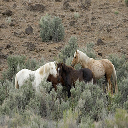

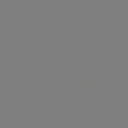

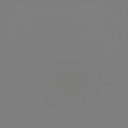

epoch: 1/5000, batch: 100/1067, GA2B_loss: 5.648100852966309, GB2A_loss: 5.751819610595703
                             DA_loss: 0.002174324356019497, DB_loss: 0.0056798518635332584, CYC_loss: 0.966444730758667
epoch: 1/5000, batch: 200/1067, GA2B_loss: 4.170012474060059, GB2A_loss: 4.2718353271484375
                             DA_loss: 0.001497494988143444, DB_loss: 0.0023308214731514454, CYC_loss: 0.6598961353302002
epoch: 1/5000, batch: 300/1067, GA2B_loss: 3.6283230781555176, GB2A_loss: 3.472487449645996
                             DA_loss: 0.010848907753825188, DB_loss: 0.0052504208870232105, CYC_loss: 0.5273383855819702
epoch: 1/5000, batch: 400/1067, GA2B_loss: 4.322816848754883, GB2A_loss: 3.445986747741699
                             DA_loss: 0.21499183773994446, DB_loss: 3.5929513160226634e-06, CYC_loss: 0.6654690504074097
epoch: 1/5000, batch: 500/1067, GA2B_loss: 3.464816093444824, GB2A_loss: 3.334111452102661
                             DA_loss: 0.3096119165420532, DB

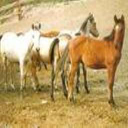

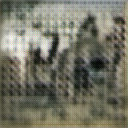

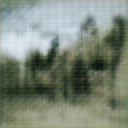

epoch: 2/5000, batch: 100/1067, GA2B_loss: 3.81648325920105, GB2A_loss: 3.093308687210083
                             DA_loss: 0.11635822057723999, DB_loss: 0.293131560087204, CYC_loss: 0.564469575881958
epoch: 2/5000, batch: 200/1067, GA2B_loss: 3.7555580139160156, GB2A_loss: 3.3697729110717773
                             DA_loss: 0.027961697429418564, DB_loss: 2.5875897335936315e-05, CYC_loss: 0.5537713170051575
epoch: 2/5000, batch: 300/1067, GA2B_loss: 3.2058327198028564, GB2A_loss: 2.6436169147491455
                             DA_loss: 0.07650268822908401, DB_loss: 0.03463947772979736, CYC_loss: 0.4448873996734619
epoch: 2/5000, batch: 400/1067, GA2B_loss: 4.096065521240234, GB2A_loss: 3.9033632278442383
                             DA_loss: 0.13594050705432892, DB_loss: 6.163751822896302e-05, CYC_loss: 0.6236112117767334
epoch: 2/5000, batch: 500/1067, GA2B_loss: 3.477109432220459, GB2A_loss: 3.7051944732666016
                             DA_loss: 0.007711232174187899, DB_lo

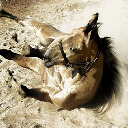

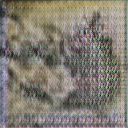

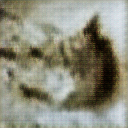

epoch: 3/5000, batch: 100/1067, GA2B_loss: 2.91788911819458, GB2A_loss: 2.683173656463623
                             DA_loss: 0.26452767848968506, DB_loss: 0.06955970823764801, CYC_loss: 0.5039552450180054
epoch: 3/5000, batch: 200/1067, GA2B_loss: 3.763479709625244, GB2A_loss: 3.2271969318389893
                             DA_loss: 0.09592165797948837, DB_loss: 0.033263467252254486, CYC_loss: 0.5802329778671265
epoch: 3/5000, batch: 300/1067, GA2B_loss: 3.548128604888916, GB2A_loss: 2.742844581604004
                             DA_loss: 0.25999724864959717, DB_loss: 0.0030684005469083786, CYC_loss: 0.5215269327163696
epoch: 3/5000, batch: 400/1067, GA2B_loss: 3.1404781341552734, GB2A_loss: 2.977313280105591
                             DA_loss: 0.14032675325870514, DB_loss: 0.008214601315557957, CYC_loss: 0.44270533323287964
epoch: 3/5000, batch: 500/1067, GA2B_loss: 3.455836296081543, GB2A_loss: 3.5701498985290527
                             DA_loss: 0.01977257989346981, DB_loss

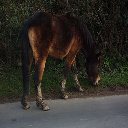

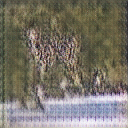

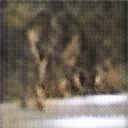

epoch: 4/5000, batch: 100/1067, GA2B_loss: 2.7847509384155273, GB2A_loss: 2.883721351623535
                             DA_loss: 0.031360797584056854, DB_loss: 0.17971283197402954, CYC_loss: 0.41832515597343445
epoch: 4/5000, batch: 200/1067, GA2B_loss: 3.7769250869750977, GB2A_loss: 3.822396993637085
                             DA_loss: 0.05612428858876228, DB_loss: 0.11535346508026123, CYC_loss: 0.5937780737876892
epoch: 4/5000, batch: 300/1067, GA2B_loss: 2.945723533630371, GB2A_loss: 2.929847240447998
                             DA_loss: 0.009336802177131176, DB_loss: 0.02234591357409954, CYC_loss: 0.40809357166290283
epoch: 4/5000, batch: 400/1067, GA2B_loss: 2.7987184524536133, GB2A_loss: 2.8930530548095703
                             DA_loss: 0.08554848283529282, DB_loss: 0.35220471024513245, CYC_loss: 0.5098466873168945
epoch: 4/5000, batch: 500/1067, GA2B_loss: 3.4036526679992676, GB2A_loss: 3.473449230194092
                             DA_loss: 0.14047932624816895, DB_lo

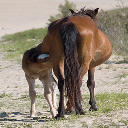

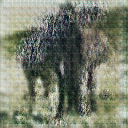

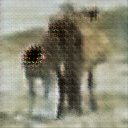

epoch: 5/5000, batch: 100/1067, GA2B_loss: 2.9207937717437744, GB2A_loss: 2.9147117137908936
                             DA_loss: 0.052550844848155975, DB_loss: 0.14612329006195068, CYC_loss: 0.48328664898872375
epoch: 5/5000, batch: 200/1067, GA2B_loss: 3.2299137115478516, GB2A_loss: 2.8684840202331543
                             DA_loss: 0.021136222407221794, DB_loss: 0.11397536098957062, CYC_loss: 0.4465394914150238
epoch: 5/5000, batch: 300/1067, GA2B_loss: 2.617544412612915, GB2A_loss: 2.7185211181640625
                             DA_loss: 0.29200559854507446, DB_loss: 0.2876342236995697, CYC_loss: 0.3713040351867676
epoch: 5/5000, batch: 400/1067, GA2B_loss: 3.27589750289917, GB2A_loss: 3.06101655960083
                             DA_loss: 0.18947947025299072, DB_loss: 0.2216424196958542, CYC_loss: 0.5341770052909851
epoch: 5/5000, batch: 500/1067, GA2B_loss: 2.306936502456665, GB2A_loss: 2.691300392150879
                             DA_loss: 0.05412929505109787, DB_loss: 0

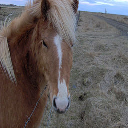

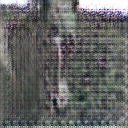

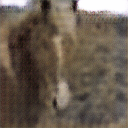

epoch: 6/5000, batch: 100/1067, GA2B_loss: 2.501342535018921, GB2A_loss: 2.5596673488616943
                             DA_loss: 0.30793339014053345, DB_loss: 0.16679614782333374, CYC_loss: 0.34301668405532837
epoch: 6/5000, batch: 200/1067, GA2B_loss: 2.4517030715942383, GB2A_loss: 2.3326125144958496
                             DA_loss: 0.08477580547332764, DB_loss: 0.014234522357583046, CYC_loss: 0.33975958824157715
epoch: 6/5000, batch: 300/1067, GA2B_loss: 4.27150821685791, GB2A_loss: 4.281357765197754
                             DA_loss: 0.003500520484521985, DB_loss: 0.0707063227891922, CYC_loss: 0.6651118397712708
epoch: 6/5000, batch: 400/1067, GA2B_loss: 4.009206295013428, GB2A_loss: 3.7600979804992676
                             DA_loss: 0.009666969999670982, DB_loss: 0.2641831040382385, CYC_loss: 0.6036224365234375
epoch: 6/5000, batch: 500/1067, GA2B_loss: 3.0500545501708984, GB2A_loss: 3.0156755447387695
                             DA_loss: 0.06622534990310669, DB_los

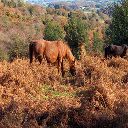

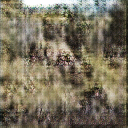

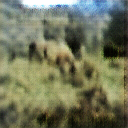

epoch: 7/5000, batch: 100/1067, GA2B_loss: 3.407693386077881, GB2A_loss: 3.2874128818511963
                             DA_loss: 0.004971392918378115, DB_loss: 0.03100905567407608, CYC_loss: 0.4928358793258667
epoch: 7/5000, batch: 200/1067, GA2B_loss: 3.767988920211792, GB2A_loss: 3.598165988922119
                             DA_loss: 0.025804078206419945, DB_loss: 0.08443660289049149, CYC_loss: 0.5568050742149353
epoch: 7/5000, batch: 300/1067, GA2B_loss: 3.7474894523620605, GB2A_loss: 3.3861513137817383
                             DA_loss: 0.05399104207754135, DB_loss: 0.004431982524693012, CYC_loss: 0.5853844881057739
epoch: 7/5000, batch: 400/1067, GA2B_loss: 2.903069019317627, GB2A_loss: 2.6838631629943848
                             DA_loss: 0.03614986687898636, DB_loss: 0.005557951517403126, CYC_loss: 0.396342009305954
epoch: 7/5000, batch: 500/1067, GA2B_loss: 3.8555827140808105, GB2A_loss: 3.2711856365203857
                             DA_loss: 0.10269758105278015, DB_lo

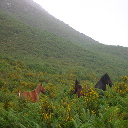

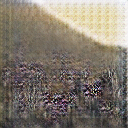

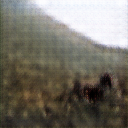

epoch: 8/5000, batch: 100/1067, GA2B_loss: 2.695829391479492, GB2A_loss: 2.871089220046997
                             DA_loss: 0.005325204227119684, DB_loss: 0.015139755792915821, CYC_loss: 0.40271246433258057
epoch: 8/5000, batch: 200/1067, GA2B_loss: 3.2020318508148193, GB2A_loss: 3.1242427825927734
                             DA_loss: 0.0018184748478233814, DB_loss: 0.0134426923468709, CYC_loss: 0.4480555057525635
epoch: 8/5000, batch: 300/1067, GA2B_loss: 2.5872809886932373, GB2A_loss: 2.4833474159240723
                             DA_loss: 0.009397937916219234, DB_loss: 0.013856057077646255, CYC_loss: 0.3476962149143219
epoch: 8/5000, batch: 400/1067, GA2B_loss: 3.493122100830078, GB2A_loss: 2.6952016353607178
                             DA_loss: 0.16739480197429657, DB_loss: 0.003973903134465218, CYC_loss: 0.5034443140029907
epoch: 8/5000, batch: 500/1067, GA2B_loss: 2.962265729904175, GB2A_loss: 2.9573802947998047
                             DA_loss: 0.05748298019170761, D

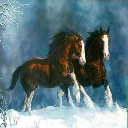

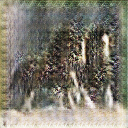

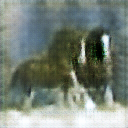

epoch: 9/5000, batch: 100/1067, GA2B_loss: 2.5370776653289795, GB2A_loss: 2.5369150638580322
                             DA_loss: 0.027902614325284958, DB_loss: 0.09256937354803085, CYC_loss: 0.3177333474159241
epoch: 9/5000, batch: 200/1067, GA2B_loss: 2.9183783531188965, GB2A_loss: 3.000652313232422
                             DA_loss: 0.15081177651882172, DB_loss: 0.00833163969218731, CYC_loss: 0.41424208879470825
epoch: 9/5000, batch: 300/1067, GA2B_loss: 2.574004650115967, GB2A_loss: 2.4238762855529785
                             DA_loss: 0.006353873759508133, DB_loss: 0.0005519245169125497, CYC_loss: 0.32623714208602905
epoch: 9/5000, batch: 400/1067, GA2B_loss: 2.6594767570495605, GB2A_loss: 2.3353159427642822
                             DA_loss: 0.32397279143333435, DB_loss: 0.03670470789074898, CYC_loss: 0.42558932304382324
epoch: 9/5000, batch: 500/1067, GA2B_loss: 4.366215229034424, GB2A_loss: 4.350244522094727
                             DA_loss: 0.006460544653236866, 

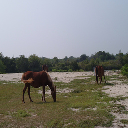

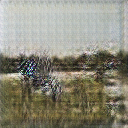

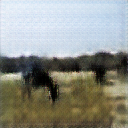

epoch: 10/5000, batch: 100/1067, GA2B_loss: 3.523379325866699, GB2A_loss: 3.542376756668091
                             DA_loss: 0.0437338687479496, DB_loss: 0.00121520203538239, CYC_loss: 0.5230772495269775
epoch: 10/5000, batch: 200/1067, GA2B_loss: 2.8706541061401367, GB2A_loss: 3.0474672317504883
                             DA_loss: 0.3607833683490753, DB_loss: 0.0062159327790141106, CYC_loss: 0.4162093997001648
epoch: 10/5000, batch: 300/1067, GA2B_loss: 2.925617218017578, GB2A_loss: 2.782362222671509
                             DA_loss: 0.02751096524298191, DB_loss: 0.012442626059055328, CYC_loss: 0.4298495054244995
epoch: 10/5000, batch: 400/1067, GA2B_loss: 3.028620958328247, GB2A_loss: 2.6987547874450684
                             DA_loss: 0.1505025178194046, DB_loss: 0.05733506381511688, CYC_loss: 0.40623095631599426
epoch: 10/5000, batch: 500/1067, GA2B_loss: 3.3152716159820557, GB2A_loss: 3.062368869781494
                             DA_loss: 0.18262843787670135, DB_l

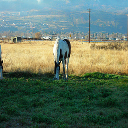

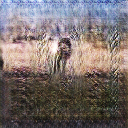

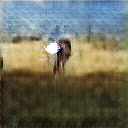

epoch: 11/5000, batch: 100/1067, GA2B_loss: 3.8079426288604736, GB2A_loss: 3.945918083190918
                             DA_loss: 0.0003153827856294811, DB_loss: 0.0049342564307153225, CYC_loss: 0.5991034507751465
epoch: 11/5000, batch: 200/1067, GA2B_loss: 2.8924198150634766, GB2A_loss: 2.589458465576172
                             DA_loss: 0.02954750508069992, DB_loss: 0.06602662801742554, CYC_loss: 0.40257108211517334
epoch: 11/5000, batch: 300/1067, GA2B_loss: 3.909226417541504, GB2A_loss: 3.2378523349761963
                             DA_loss: 0.14597859978675842, DB_loss: 0.0022876851726323366, CYC_loss: 0.6053112745285034
epoch: 11/5000, batch: 400/1067, GA2B_loss: 3.49505877494812, GB2A_loss: 3.1999359130859375
                             DA_loss: 0.013986317440867424, DB_loss: 0.0002048908791039139, CYC_loss: 0.5003862977027893
epoch: 11/5000, batch: 500/1067, GA2B_loss: 2.6778969764709473, GB2A_loss: 1.8773521184921265
                             DA_loss: 0.1711960136890

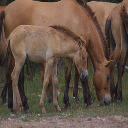

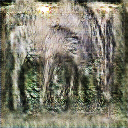

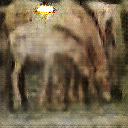

epoch: 12/5000, batch: 100/1067, GA2B_loss: 1.8192883729934692, GB2A_loss: 2.395500421524048
                             DA_loss: 0.006336733233183622, DB_loss: 0.14476332068443298, CYC_loss: 0.32118067145347595
epoch: 12/5000, batch: 200/1067, GA2B_loss: 3.3568170070648193, GB2A_loss: 3.074404239654541
                             DA_loss: 0.0235470961779356, DB_loss: 0.021058464422822, CYC_loss: 0.49106019735336304
epoch: 12/5000, batch: 300/1067, GA2B_loss: 3.296046495437622, GB2A_loss: 3.0720930099487305
                             DA_loss: 0.008105436339974403, DB_loss: 0.0024938839487731457, CYC_loss: 0.46026334166526794
epoch: 12/5000, batch: 400/1067, GA2B_loss: 2.9638049602508545, GB2A_loss: 2.210242986679077
                             DA_loss: 0.38392606377601624, DB_loss: 0.007674898952245712, CYC_loss: 0.43898680806159973
epoch: 12/5000, batch: 500/1067, GA2B_loss: 3.0330348014831543, GB2A_loss: 2.921658515930176
                             DA_loss: 0.02924097701907158

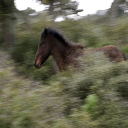

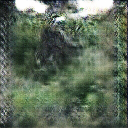

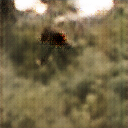

epoch: 13/5000, batch: 100/1067, GA2B_loss: 3.57012939453125, GB2A_loss: 3.6007890701293945
                             DA_loss: 0.00030686380341649055, DB_loss: 0.0002398399665253237, CYC_loss: 0.5222996473312378
epoch: 13/5000, batch: 200/1067, GA2B_loss: 2.94539737701416, GB2A_loss: 3.1004791259765625
                             DA_loss: 0.04288431257009506, DB_loss: 0.04577089473605156, CYC_loss: 0.4253259301185608
epoch: 13/5000, batch: 300/1067, GA2B_loss: 2.4920997619628906, GB2A_loss: 2.6738686561584473
                             DA_loss: 0.005566420033574104, DB_loss: 0.021956361830234528, CYC_loss: 0.3727908730506897
epoch: 13/5000, batch: 400/1067, GA2B_loss: 2.473828077316284, GB2A_loss: 2.4840433597564697
                             DA_loss: 0.005266644526273012, DB_loss: 0.10776667296886444, CYC_loss: 0.3252490162849426
epoch: 13/5000, batch: 500/1067, GA2B_loss: 1.9414862394332886, GB2A_loss: 2.255786895751953
                             DA_loss: 0.0149716306477785

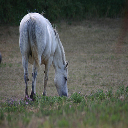

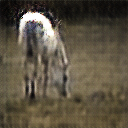

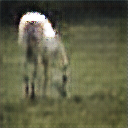

In [0]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc = model.step_optimization(real_samplesA, real_samplesB, lambda_cyc)
        
        # Show current loss
        if (n_batch) % 100 == 0:
            print(f"epoch: {epoch+1}/{num_epochs}, batch: {n_batch}/{len(data_loader_train)}, GA2B_loss: {loss_gA2B}, GB2A_loss: {loss_gB2A}")
            print(f"                             DA_loss: {loss_dA}, DB_loss: {loss_dB}, CYC_loss: {loss_cyc}")    
          
        # Show fake samples
        if n_batch == 10:
            fake_samplesA = model._generatorA2B(real_samplesA)
            fake_samplesB = model._generatorB2A(fake_samplesA)
            display_batch_images(real_samplesA)
            display_batch_images(fake_samplesA.detach())
            display_batch_images(fake_samplesB.detach())
